# Definition of age for customers at "Hleb-Sol" store

The network supermarket "Hleb-Sol" is introducing a computer vision system to process customer photos. The photo fixation area will help determine the age of customers in order to: 

• Analyze purchases and suggest products that may interest buyers within this age group;
• Control the honesty of cashiers when selling alcoholic beverages.

We will build a model that can estimate a person's approximate age from their photo. We have a dataset of photos with corresponding ages.

Here are the our steps to complete the project:

1. Conduct an exploratory data analysis of the image set.
2. Prepare the data for training.
3. Train a neural network and calculate its quality.

Our quality metric will be Mean Absolute Error (MAE). We need to achieve an MAE on the test dataset less than or equal to 8.   
Given that our current MAE is 5.4, if we get an MAE below 7, it would be a good result!

## Exploratory Data Analysis

In [ ]:
# importing libraries beforee the project starts
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator 

In [ ]:
# loading data of target labels
pth1 = '/datasets/faces/labels.csv'

if os.path.exists(pth1):
    labels = pd.read_csv(pth1)
else:
    print('Something is wrong')

In [ ]:
# look at the dimension
display(labels.shape)

# and types of data
labels.info()

(7591, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
# lets see a few lines of the dataset
display(labels.head())
display(labels.tail())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


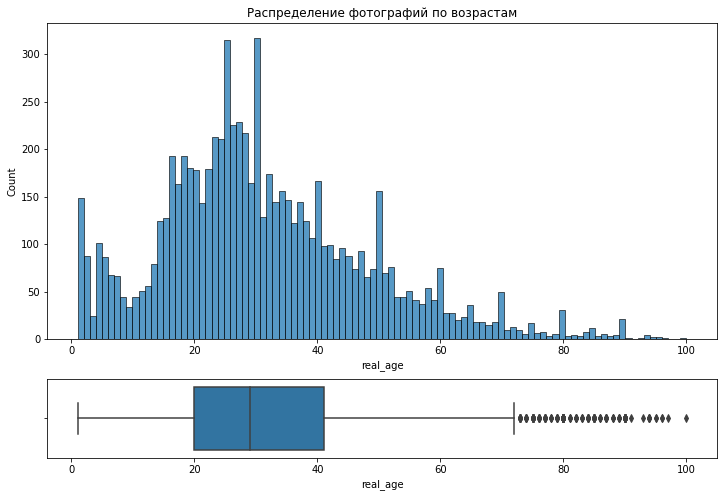

In [ ]:
# looka at the distribution of data by age

fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [4, 1]})

sns.histplot(data=labels, x='real_age', bins=100, ax=axes[0])
axes[0].set_title('The distribution of photos by age')

sns.boxplot(data=labels, x='real_age', ax=axes[1]);

In [ ]:
# load the dataset with photos
datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# initialize flow generator of photos
faces_generator=datagen.flow_from_dataframe(
    dataframe=labels,
    directory="/datasets/faces/final_files",
    x_col="file_name",
    y_col="real_age",
    batch_size=32,
    seed=12345,
    class_mode="raw",
    target_size=(224,224))

Found 7591 validated image filenames.


In [ ]:
# take first batch
first_batch = next(faces_generator)

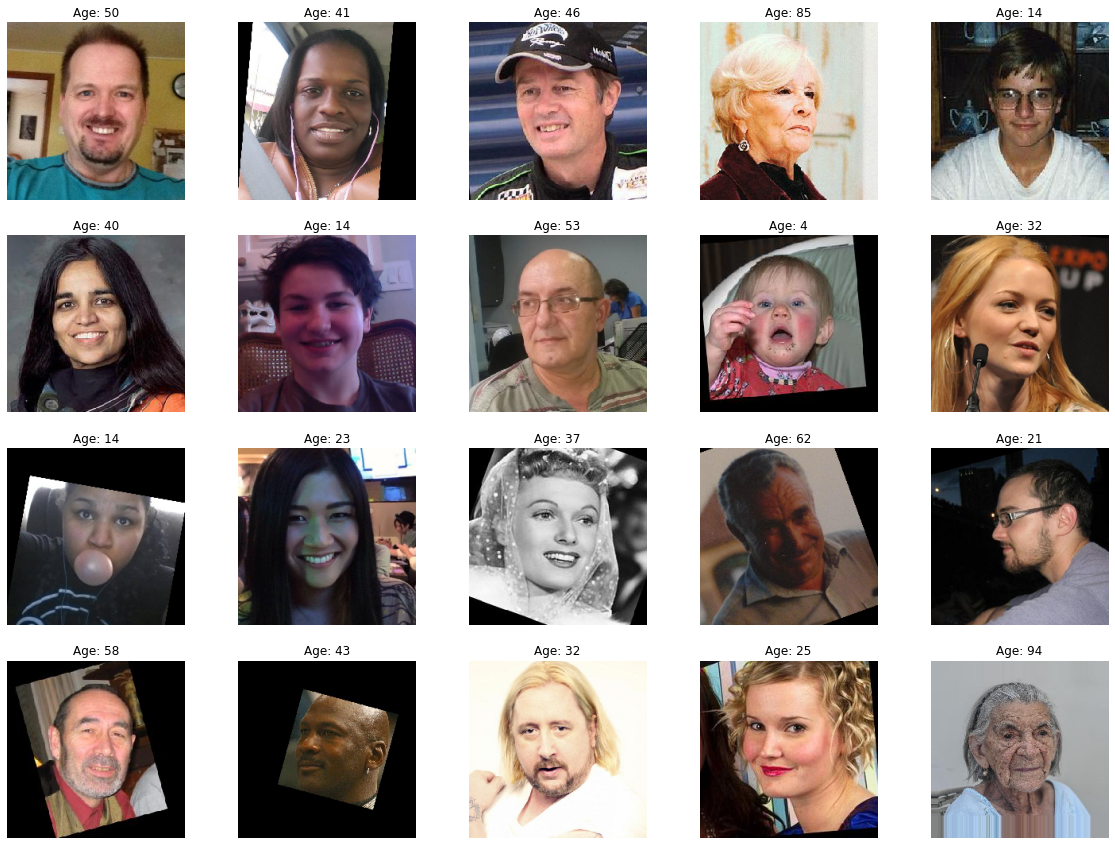

In [ ]:
# extract the images from the batch 
images, labels_age = first_batch

# display the first 20 images
plt.figure(figsize=(20, 15))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Age: {labels_age[i]}')
    plt.axis('off')  # remove axes from the sides of the photo

plt.show()

**Conclusion**

The dataset consists of 7591 images with age labels, with uneven and non-normal distributions of data:

* Most data points are for children under 10 years old
* Most data points are for adults between 15-60 years old
* Data for other age categories is negligible

This suggests that the model has a good chance of learning to detect these most common age ranges, but may struggle with detecting less frequent age categories.
Some images show distortions or shifts relative to axes, which could be beneficial for training.

## Training model

We transfer the code for training the model and displaying its results on the screen.

(The code in this section is run on a separate GPU training environment, so it is formatted as plain text code)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):

    labels = pd.read_csv(path+'labels.csv')

    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1./255,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+"/final_files/",
        x_col="file_name",
        y_col="real_age",
        batch_size=16,
        seed=12345,
        class_mode="raw",
        subset='training',
        target_size=(224,224))

    return train_datagen_flow


def load_test(path):

    labels = pd.read_csv(path+'labels.csv')

    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+"/final_files",
        x_col="file_name",
        y_col="real_age",
        batch_size=16,
        seed=12345,
        class_mode="raw",
        subset='validation',
        target_size=(224,224))

    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    return model


```

```
# results of model training and final metric

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 120s - loss: 204.1424 - mae: 10.5975 - val_loss: 324.0522 - val_mae: 13.3229
Epoch 2/10
356/356 - 110s - loss: 115.9201 - mae: 8.1569 - val_loss: 159.3961 - val_mae: 9.5831
Epoch 3/10
356/356 - 110s - loss: 92.1957 - mae: 7.3610 - val_loss: 102.8694 - val_mae: 7.6227
Epoch 4/10
356/356 - 110s - loss: 80.1216 - mae: 6.8058 - val_loss: 100.4119 - val_mae: 7.4856
Epoch 5/10
356/356 - 110s - loss: 65.1257 - mae: 6.1973 - val_loss: 103.5512 - val_mae: 7.4974
Epoch 6/10
356/356 - 111s - loss: 60.0807 - mae: 5.9505 - val_loss: 90.6147 - val_mae: 6.9201
Epoch 7/10
356/356 - 111s - loss: 54.4522 - mae: 5.6868 - val_loss: 81.9113 - val_mae: 6.9922
Epoch 8/10
356/356 - 111s - loss: 45.5492 - mae: 5.1873 - val_loss: 124.4674 - val_mae: 8.3966
Epoch 9/10
356/356 - 110s - loss: 44.1967 - mae: 5.0659 - val_loss: 76.1574 - val_mae: 6.5687
Epoch 10/10
356/356 - 110s - loss: 41.1910 - mae: 4.9282 - val_loss: 78.8243 - val_mae: 6.8976

119/119 - 11s - loss: 78.8243 - mae: 6.8976
Test MAE: 6.8976

```

## Analysis of trained model

We implemented the face recognition project using a combined architecture for the trained model, based on ResNet50 and several additional fully connected layers on top of the base model with an MSE loss function (choosing a faster training approach), Adam optimization algorithm, and original MAE metric.

The dataset was split into 3:1 proportion for training and testing. After selecting 10 epochs for training, the desired result on the MAE metric was achieved already at epoch 3, resulting in a final model performance with an **MAE of 6.8976**.

Considering this outcome, the model is recommended for use.    